<a href="https://colab.research.google.com/github/KatherLab/synth-user-study/blob/main/GLIDE_with_optional_CLIP_for_medical_data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLIDE for image generation with optional CLIP guidance

This script will take a text prompt and generate images with GLIDE, with or without CLIP guidance. It is based on the publicly available GLIDE model by OpenAI, available at https://github.com/openai/glide-text2im

The authors are grateful to the anonymous Twitter user [@ai_curio](https://twitter.com/ai_curio) who was among the first to implement the OpenAI model in a Python notebook, which was very helpful for this study. Also, we  use the following package: Robyn Speer. (2019). ftfy (Version 5.5). Zenodo. http://doi.org/10.5281/zenodo.2591652


First, we will download the models and install all packages

In [ ]:
# download the model
!git clone https://github.com/openai/glide-text2im.git  # download GLIDE
%cd /content/glide-text2im/

# install packages
!pip install -e .                                       # install GLIDE
!pip install ftfy                                       # fix unicode in input
!pip install python-slugify                             # for file names

# import packages
from PIL import Image                 # for image manipulation
from IPython.display import display   # for inline visualization of image
import torch as th                    # import torch for neural networks
import torch.nn as nn

# import CLIP functions
from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

# GPU checking and import
assert(th.cuda.is_available())
device = th.device('cuda')

# import additional packages
import shutil                     # for zipping the result
import multiprocessing
import torch                      # for neural networks
import os                         # for file system operations
from slugify import slugify       # to make valid file names
import random                     # for random string name
import string                     # for random string name
from google.colab import output   # for output in this notebook
from google.colab import files    # for file download
from psutil import virtual_memory

# define and create output folder
parent_dir = "/content/output/"
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# GPU stats
!nvidia-smi

Cloning into 'glide-text2im'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 66 (delta 23), reused 34 (delta 14), pack-reused 10
Unpacking objects: 100% (66/66), done.
/content/glide-text2im
Obtaining file:///content/glide-text2im
  Attempting uninstall: glide-text2im
    Found existing installation: glide-text2im 0.0.0
    Can't uninstall 'glide-text2im'. No files were found to uninstall.
  Running setup.py develop for glide-text2im
Wed Jan  5 21:02:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                          

Now, we will initialize all models: the GLIDE generator, the GLIDE upsampler and the CLIP model (for guidance)

In [ ]:
# initialize GLIDE generator model (diffusion model)
options = model_and_diffusion_defaults()
options['use_fp16'] = True
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('N params in generator ', sum(x.numel() for x in model.parameters()))

# initialize GLIDE upsampler model (from 64x64 to 256x256)
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = True
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('N params in upsampler ', sum(x.numel() for x in model_up.parameters()))

# initialize CLIP model
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

N params in generator  385030726


  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

N params in upsampler  398361286


  0%|          | 0.00/346M [00:00<?, ?iB/s]

  0%|          | 0.00/287M [00:00<?, ?iB/s]

<All keys matched successfully>

Next, we will define auxiliary functions

In [ ]:
def show_images(batch: th.Tensor): # display images inline in notebook
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    img = Image.fromarray(reshaped.numpy())
    display(img)
    return img

def model_fn(x_t, ts, **kwargs): # classifier-free sampling funcion (no CLIP)
    guidance_scale=3.0
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# create the images
def create_images(prompt,device,model,batch_size=2,clip_guidance=False,clip_model=[]):
  # Create the text tokens to feed to the model.
  tokens = model.tokenizer.encode(prompt)
  tokens, mask = model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  )
  if not clip_guidance:
    print('generating images without CLIP guidance')
    # Create the classifier-free guidance tokens (empty)
    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
        [], options['text_ctx'])
    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor(
            [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
        ),
        mask=th.tensor(
            [mask] * batch_size + [uncond_mask] * batch_size,
            dtype=th.bool,
            device=device,
        ),
    )
    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model.del_cache()
    return samples
  else:
    print('generating images WITH CLIP guidance')
    # Pack the tokens together into model kwargs.
    model_kwargs = dict(
        tokens=th.tensor([tokens] * batch_size, device=device),
        mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
    )
    # Setup guidance function for CLIP model.
    guidance_scale=3.0
    cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)
    # Sample from the base model.
    model.del_cache()
    samples = diffusion.p_sample_loop(
        model,
        (batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=cond_fn,
    )
    model.del_cache()
    return samples

# upsample from 64 to 256 edge length
def upsample_images(prompt,samples,model_up,device,batch_size=2,upsample_temp=0.997):
  tokens = model_up.tokenizer.encode(prompt)
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )
  # Create the model conditioning dict.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,
      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )
  # Sample from the base model.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  up_samples = diffusion_up.ddim_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model_up.del_cache()
  return up_samples

# main function to generate images
def generate_and_show(prompt,device,model,model_up,clip_model,batch_size,clip_guidance):
  print("\n\n"+"Starting new image generation."+"\n"+"prompt = "+prompt)
  samples = create_images(prompt,device,model,batch_size,clip_guidance,clip_model)
  if do_upsample:
    up_samples = upsample_images(prompt,samples,model_up,device,batch_size=batch_size,upsample_temp=0.997)
    img = show_images(up_samples) # Show the output 256x256
  else:
    img = show_images(samples) # Show the output 64x64
  return img

Now, finally, we can iterate the prompts and generate the images. 



Starting new image generation.
prompt = a photo of a dog under a tree
generating images WITH CLIP guidance


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

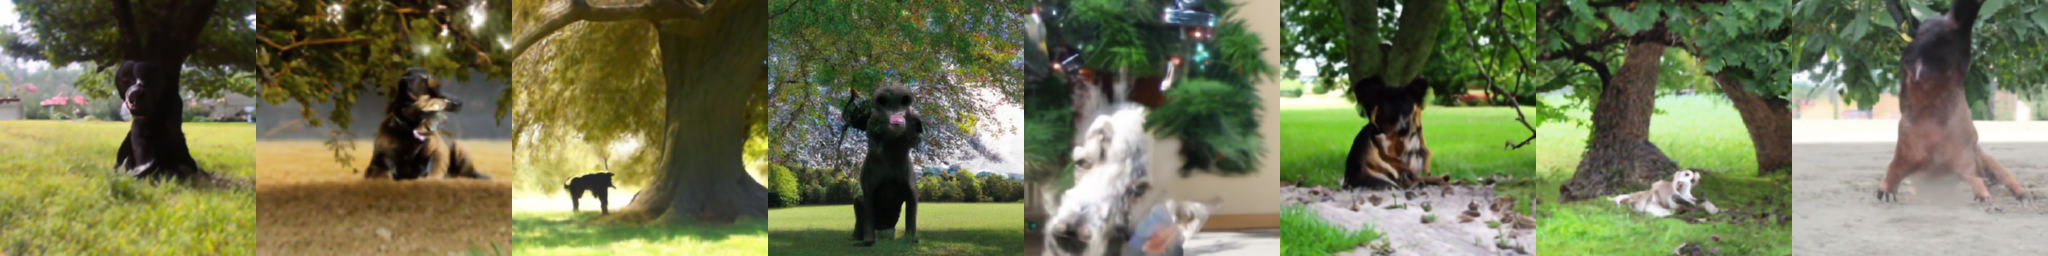

random ID WXAX7UA75AGK


Starting new image generation.
prompt = a photo of blood vessels
generating images WITH CLIP guidance


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

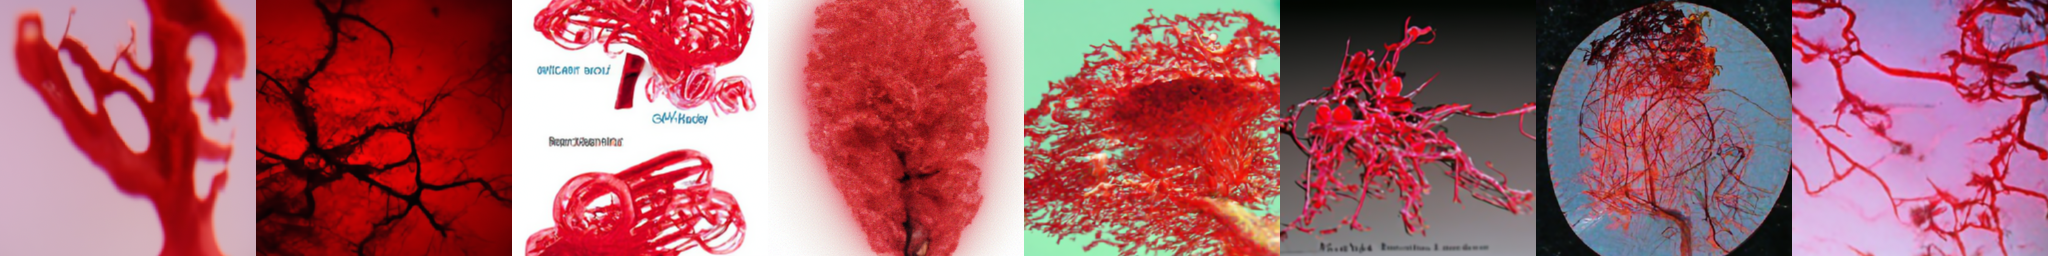

random ID 53EZYL0IK6ZU


Starting new image generation.
prompt = a photo of the brain
generating images WITH CLIP guidance


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

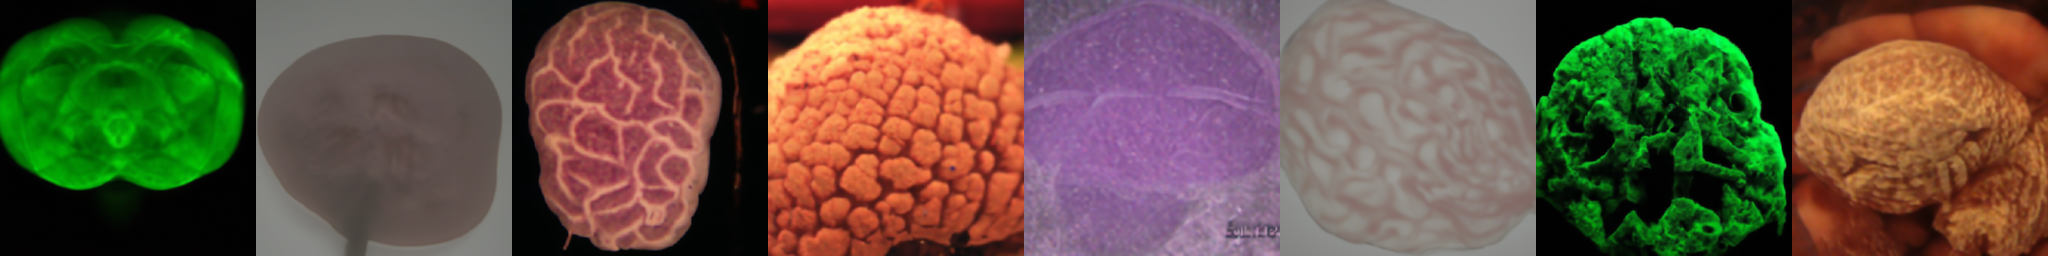

random ID T7VQ13A17Q20


Starting new image generation.
prompt = a histopathological image of a dog under a tree
generating images WITH CLIP guidance


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

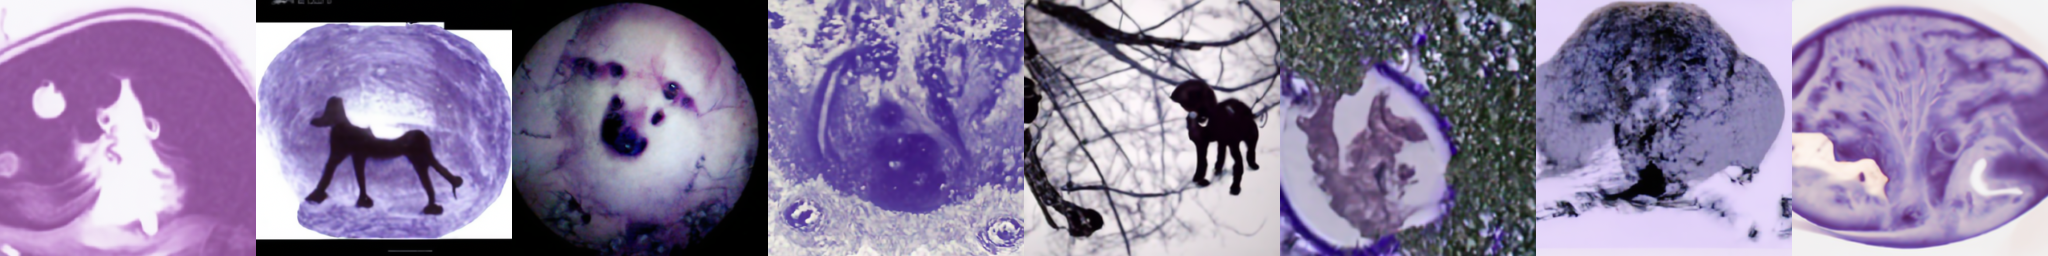

random ID OTFSWQRY0XWN


Starting new image generation.
prompt = a histopathological image of blood vessels
generating images WITH CLIP guidance


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

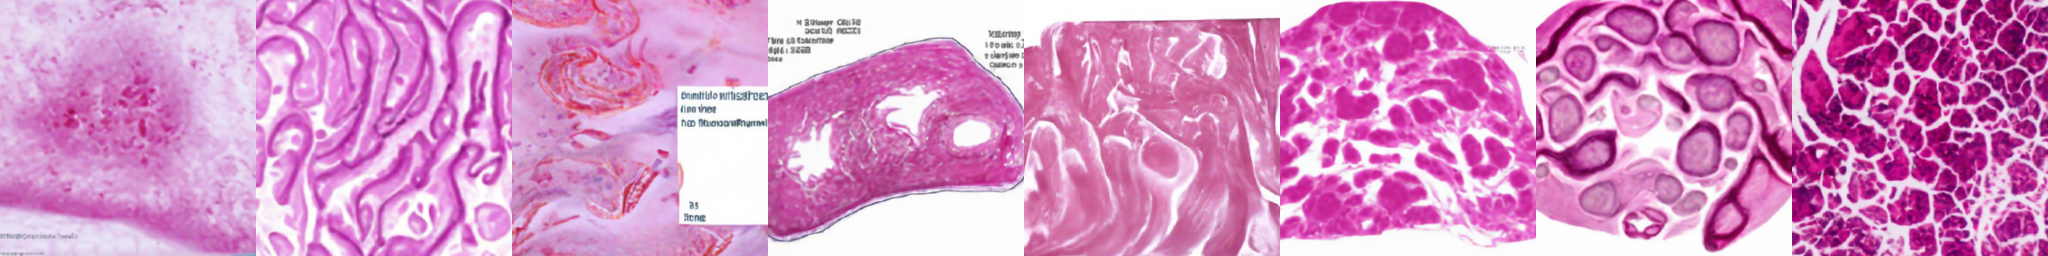

random ID 5OH7Z6IGIIAU


Starting new image generation.
prompt = a histopathological image of the brain
generating images WITH CLIP guidance


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

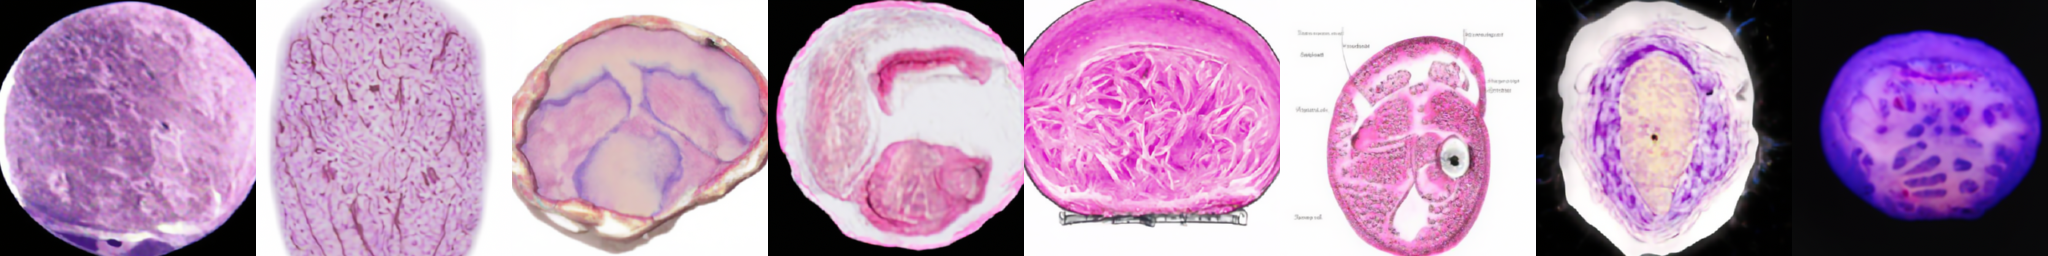

random ID L9ZTOZSDWVMY


In [ ]:
# define prompts
all1 = ["a photo of",
        "a histopathological image of"]
all2 = ["a dog under a tree",
        "blood vessels",
        "the brain"]

# define parameters
batch_size = 8
do_upsample = True
use_clip = True
do_save = True

# iterate prompts
for prompt1 in all1:
  for prompt2 in all2:
    prompt = prompt1 + " " + prompt2
    img = generate_and_show(prompt,device,model,model_up,clip_model,batch_size,clip_guidance=use_clip)
    fn = ''.join(random.choices(string.ascii_uppercase + string.digits, k=12))
    print('random ID '+fn)
    if do_save: 
      imname = os.path.join(parent_dir,(slugify(prompt1)+slugify(prompt2)+"_"+fn+".png"))
      img.save(imname, format="png")

In [ ]:
if do_save: # zip and download the images
  shutil.make_archive(("/content/compr_orig"), 'zip', parent_dir)
  files.download("/content/compr_orig.zip")
  print('finished and cleaned up')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

finished and cleaned up
